In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install vit-keras tensorflow tensorflow-addons

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

from PIL import Image
from vit_keras import vit
from skimage.metrics import structural_similarity

### Load CNN

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset/new-models/cnn/resnet50_pneumonia_detection_v2.h5')

### Load ViT

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset/new-models/vit/vitB32_pneumonia_detection.tf')

### RED-Attack: Resource Efficient Decision based Attack

In [ ]:

height = 224
width = 224

def max_diff(img1, img2):
    return np.amax(img1-img2)

def pred(image):
    data = []
    data.append(image)
    X_test = np.array(data)
    X_test = X_test.astype('float32')/255
    X_test = X_test.reshape(1,height,width,3)
    predict_x=model.predict(X_test)
    pred_target_image = 1 if predict_x[0, 0] > 0.5 else 0
    return pred_target_image

def boundary_estimation(source,target, delta_min):
    print("Boundary Estimation")
    adv = (source+target)/2
    delta = max_diff(source, target)
    k = pred(adv)
    left = source
    right = target
    while delta > delta_min:
        print('stuck in while -> boundary_estimation')
        if pred(source) != k:
            right = adv
        else:
            left = adv
        adv = (left+right)/2.0
        k = pred(adv)
        delta = max_diff(left, right)
    return right

def go_out(source,iout,alpha):
    print("Go Out")
    i_diff = iout - source
    pred_source = pred(source)
    inew = iout
    speedbreaker = 1
    while (pred(inew)==pred_source):
        print('stuck in while -> go_out')
        inew = inew + alpha*(i_diff)
        # update in code to increase alpha to make code faster
        speedbreaker = speedbreaker + 1
        if speedbreaker > 10:
            print('[][][] Go out speed breaker [][][]')
            break

    return inew

def array_diff(A):
  return (A*A).sum()

def gradient_estimation(source, target,adv,n,theta):
    print("Gradient Estimation")
    Io = np.zeros((height*width*3))
    X = np.random.randint(0,height*width*3,size = n)
    for i in X:
        Io[i] = 255
    Io = Io.reshape((height,width,3))
    Ii2 = adv + theta*Io
    print(pred(source),pred(adv),pred(Ii2))
    Ii2 = go_out(source,Ii2,0.01)
    print(pred(source),pred(adv),pred(Ii2))
    Ii2_new = boundary_estimation(source,Ii2,1.0)
    #comment lower line for original
    Ii2_new = go_out(source,Ii2_new,0.01)
    print(pred(source),pred(adv),pred(Ii2))
    d2 = array_diff(Ii2_new - source)
    d1 = array_diff(adv - source)
    if d2 > d1:
      return (-1,Ii2_new)
    elif d1 > d2:
      return (1,Ii2_new)
    else:
      return (0,Ii2_new)


def efficient_update(source, target, adv, I2, g, j):
    print("Efficient Update")
    delta = g*(I2 - adv)
    jump = j
    Inew = adv + jump*delta
    print(pred(source),pred(adv),pred(Inew))
    Inew = go_out(source,Inew,0.01)
    d1 = array_diff(Inew - source)
    d2 = array_diff(adv - source)
    flag, it = 0,0
    while d1 > d2:
        print('stuck in while -> efficient_update')
        jump = (jump/2.0)
        Inew = adv + jump*delta
        if(pred(Inew)==pred(source)):
            print(pred(source),pred(adv),pred(Inew))
            Inew = go_out(source,Inew,0.01)
        it = it + 1
        d1 = array_diff(Inew-source)
        if it > 100:
            break
    if d1 > d2:
        flag = 1
        print("flag is : ",flag)
        Inew = adv
    return Inew


def iteration(itr, source, target, n, theta, j, dmin):
    targett = target
    sourcee = source
    for i in range(itr):
        print("Iteration",i)
        adversarial_image = boundary_estimation(sourcee, targett, dmin)
        adversarial_image = go_out(sourcee,adversarial_image,0.01)
        (g, Iii2) = gradient_estimation(sourcee, targett, targett, n, theta)
        targett = efficient_update(sourcee, targett, adversarial_image, Iii2, g, j)

        if (pred(targett) == pred(source)):
            j = j/2.0
        fin = targett
        print("array_diff(fin-sourcee)",array_diff(fin-sourcee))
        if(pred(targett)==pred(sourcee)):
            fin = go_out(sourcee,targett,0.01)
        if(array_diff(fin-sourcee)<array_diff(adversarial_image-sourcee)):
            targett = fin
            #print("uopp")

    return fin

### Loop for folder

In [ ]:
source_path = '/content/drive/MyDrive/Dataset/xray_pneumonia/train/NORMAL'
target_path = '/content/drive/MyDrive/Dataset/xray_pneumonia/train/PNEUMONIA'

# Function to calculate structural similarity index (SSIM)
def calculate_ssim(image1, image2):
    return structural_similarity(image1, image2, channel_axis=2)

# Load the target images
target_images = []
for img_file in os.listdir(target_path):
    print(img_file)
    img_path = os.path.join(target_path, img_file)
    img = (np.asarray(Image.open(img_path)))
    if len(img.shape)==2: img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    image_from_array = Image.fromarray(img, 'RGB')
    img2 = image_from_array.resize((height, width))
    img2=np.array(img2)
    img2=img2.reshape(height,width,3)
    target_image = np.array(img2)
    if pred(target_image)==1: target_images.append(target_image)


In [ ]:

count = 0

for img in os.listdir(source_path):
    try:
        count = count + 1
        # if(count > 480):
        if(count > 1):
          break

        source_image_path = os.path.join(source_path, img)

        img = (np.asarray(Image.open(source_image_path)))
        if len(img.shape)==2: img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
        image_from_array = Image.fromarray(img, 'RGB')
        img1 = image_from_array.resize((height, width))
        img1=np.array(img1)
        img1=img1.reshape(height,width,3)
        source_image = np.array(img1)

        if pred(source_image)==1:
          count = count - 1
          continue

        # Calculate SSIM between source image and all target images
        ssim_values = [calculate_ssim(source_image, target_img) for target_img in target_images]

        # Find the index of the target image with the highest SSIM value
        most_similar_index = np.argmax(ssim_values)
        most_similar_image = target_images[most_similar_index]

        print(pred(source_image), pred(most_similar_image))

        final = iteration(2,source_image,most_similar_image,5,0.196,5.0,1.0)

        plt.figure()
        plt.grid(False)
        plt.axis('off')
        plt.imshow(final[:,:,0],cmap = "gray") # 2 iterations
        plt.savefig('/content/drive/MyDrive/Dataset/Perturbed-Images/NtoPneu/ntp-img-' + str(count) + '.jpeg', bbox_inches='tight', pad_inches=0)
        plt.close()

        print("Original Image label : ", pred(source_image))
        print("Perturbed Image label : ",pred(final))

        s = structural_similarity(source_image,final,channel_axis=2)
        print('source and final image similarity:',s)

    except Exception as e:
        print(e)

### Loop for images

In [ ]:
source_img_path = '/content/drive/MyDrive/Dataset/xray_pneumonia/train/NORMAL/IM-0158-0001.jpeg'
target_path = '/content/drive/MyDrive/Dataset/xray_pneumonia/train/PNEUMONIA'

# Function to calculate structural similarity index (SSIM)
def calculate_ssim(image1, image2):
    return structural_similarity(image1, image2, channel_axis=2)

In [ ]:

# Load the target images
target_images = []
for img_file in os.listdir(target_path):
    print(img_file)
    img_path = os.path.join(target_path, img_file)
    img = (np.asarray(Image.open(img_path)))
    if len(img.shape)==2: img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    image_from_array = Image.fromarray(img, 'RGB')
    img2 = image_from_array.resize((height, width))
    img2=np.array(img2)
    img2=img2.reshape(height,width,3)
    target_image = np.array(img2)
    if pred(target_image)==1: target_images.append(target_image)


In [ ]:

count = 0

source_image_path = source_img_path

img = (np.asarray(Image.open(source_image_path)))
if len(img.shape)==2: img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
image_from_array = Image.fromarray(img, 'RGB')
img1 = image_from_array.resize((height, width))
img1=np.array(img1)
img1=img1.reshape(height,width,3)
source_image = np.array(img1)

if pred(source_image)==1:
  print('Choose another SOURCE image since it is predicted as TARGET image')

else:
  # Calculate SSIM between source image and all target images
  ssim_values = [calculate_ssim(source_image, target_img) for target_img in target_images]

  # Find the index of the target image with the highest SSIM value
  most_similar_index = np.argmax(ssim_values)
  most_similar_image = target_images[most_similar_index]

  print('source pred:', pred(source_image), 'target pred',pred(most_similar_image), 'similarity between them:', ssim_values[most_similar_index])

1/1 [==============================] - 0s 24ms/step
source pred: 0 target pred 1 similarity between them: 0.4484547679160695


In [ ]:
final = iteration(2,source_image,most_similar_image,5,0.196,5.0,1.0)

similarity between source and final: 0.8951476395819077
1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


1/1 [==============================] - 0s 22ms/step


[]

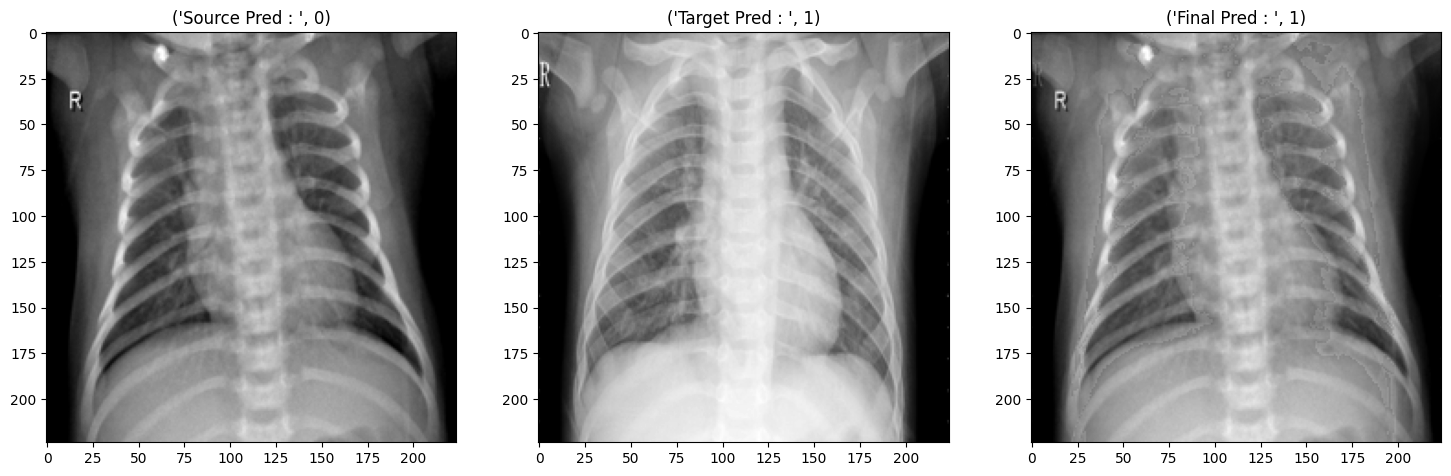

In [ ]:
# plt.savefig('/content/drive/MyDrive/Dataset/Perturbed-Images/NtoPneu/ntp-img-' + str(count) + '.jpeg', bbox_inches='tight', pad_inches=0)
# plt.close()
print('similarity between source and final:', calculate_ssim(source_image,final))

fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols = 3)
fig.set_size_inches(18, 6)
ax1.imshow(source_image[:,:,0],cmap = "gray")
ax1.set_title(("Source Pred : ",pred(source_image)))
ax2.imshow(most_similar_image[:,:,0],cmap = "gray")
ax2.set_title(("Target Pred : ",pred(most_similar_image)))
ax3.imshow(final[:,:,0],cmap = "gray")
ax3.set_title(("Final Pred : ",pred(final)))
plt.plot()
